Running Grey Wolf Optimization...

--- Running GWO Iterations ---
Iteration 01/25 | Best Fitness: -0.042194 | Best Weights: R=0.578, G=0.380, B=0.042
Iteration 02/25 | Best Fitness: -0.046524 | Best Weights: R=0.794, G=0.206, B=0.000
Iteration 03/25 | Best Fitness: -0.047353 | Best Weights: R=0.842, G=0.158, B=0.000
Iteration 04/25 | Best Fitness: -0.048558 | Best Weights: R=0.906, G=0.094, B=0.000
Iteration 05/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 06/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 07/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 08/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 09/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 10/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 11/25 | Best Fitness: -0.050536 | Best Weights: R=1.000, G=0.000, B=0.000
Iteration 

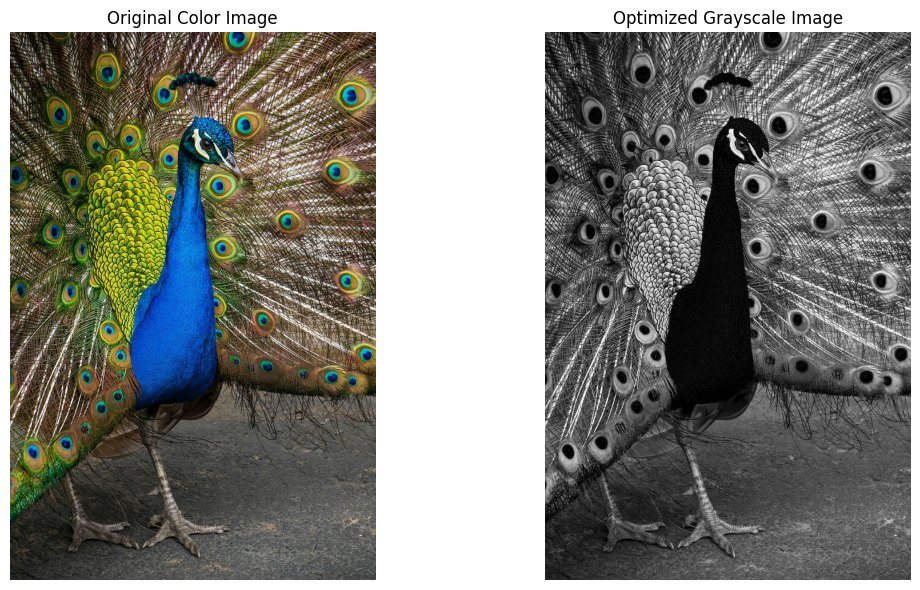

In [7]:
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# ---------------------------------------------
# Grey Wolf Optimization (GWO) for grayscale
# ---------------------------------------------

def fitness_function(weights, image):
    """Fitness: minimize the variance of local contrast (optional goal)"""
    gray = np.dot(image[..., :3], weights)
    contrast = np.var(gray)
    return -contrast  # negative because GWO minimizes fitness


def gwo(image, num_wolves=10, max_iter=30):
    """Grey Wolf Optimization to find best RGB weights"""
    dim = 3  # RGB weights
    lb = 0   # lower bound
    ub = 1   # upper bound

    # Initialize the positions of wolves
    wolves = np.random.uniform(lb, ub, (num_wolves, dim))
    # Normalize weights so w_r + w_g + w_b = 1
    wolves = np.array([w / np.sum(w) for w in wolves])

    # Initialize alpha, beta, delta wolves
    alpha, beta, delta = np.zeros(dim), np.zeros(dim), np.zeros(dim)
    alpha_score, beta_score, delta_score = float("inf"), float("inf"), float("inf")

    print("\n--- Running GWO Iterations ---")
    for iteration in range(max_iter):
        for i in range(num_wolves):
            wolves[i] = np.clip(wolves[i], lb, ub)
            wolves[i] = wolves[i] / np.sum(wolves[i])

            score = fitness_function(wolves[i], image)

            # Update Alpha, Beta, Delta
            if score < alpha_score:
                alpha_score, alpha = score, wolves[i].copy()
            elif score < beta_score:
                beta_score, beta = score, wolves[i].copy()
            elif score < delta_score:
                delta_score, delta = score, wolves[i].copy()

        a = 2 - iteration * (2 / max_iter)  # a decreases linearly from 2 to 0

        for i in range(num_wolves):
            for j in range(dim):
                r1, r2 = random.random(), random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha[j] - wolves[i][j])
                X1 = alpha[j] - A1 * D_alpha

                r1, r2 = random.random(), random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta[j] - wolves[i][j])
                X2 = beta[j] - A2 * D_beta

                r1, r2 = random.random(), random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta[j] - wolves[i][j])
                X3 = delta[j] - A3 * D_delta

                wolves[i][j] = (X1 + X2 + X3) / 3

        print(f"Iteration {iteration + 1:02d}/{max_iter} | "
      f"Best Fitness: {alpha_score: .6f} | "
      f"Best Weights: R={alpha[0]:.3f}, G={alpha[1]:.3f}, B={alpha[2]:.3f}")


    return alpha / np.sum(alpha)


# ---------------------------------------------
# MAIN PROGRAM
# ---------------------------------------------
if __name__ == "__main__":
    # Load color image
    img = cv2.imread("input.jpg")
    if img is None:
        raise FileNotFoundError("Image not found. Please put 'input.jpg' in the same folder.")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
    img_norm = img_rgb / 255.0  # normalize

    print("Running Grey Wolf Optimization...")
    best_weights = gwo(img_norm, num_wolves=12, max_iter=25)
    print(f"\nOptimal RGB Weights: {best_weights}")

    # Convert to grayscale using optimized weights
    gray_img = np.dot(img_norm[..., :3], best_weights)
    gray_img = (gray_img * 255).astype(np.uint8)

    # Save the optimized grayscale image
    cv2.imwrite("optimized_grayscale.jpg", gray_img)


    # Display original and grayscale images side-by-side using matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Color Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gray_img, cmap='gray')
    plt.title("Optimized Grayscale Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()